**Author:** Regina Hoo

**Institution:** Wellcome Sanger institute

**April, 2023**

---

## Cell hashing script

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os

import scipy as scipy
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import networkx as nx
import igraph
import glob

### Read in cellranger-cite output 

In [2]:
data_dir = '/warehouse/team292_wh01/placenta_infection/data/explant_hashing/'
meta = pd.read_csv(data_dir+'/metadata_hashing.csv',index_col=0)
meta['donor'] = meta['donor'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  2


In [3]:
meta

,donor,termination,day,pcw
sample,,,,
Pla_HDBR12261976_Pla_HDBR12261978,Hrv132,surgical,d0,12pcw
Pla_HDBR12261977_Pla_HDBR12261979,Hrv133,surgical,d0,12pcw


In [4]:
### Load matrix
data_dir_2 = '/nfs/team292/rh26/16_explant_hashing/'

In [5]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(data_dir_2+sample+'/filtered_feature_bc_matrix',gex_only=False,cache=True)) 

    # Set names of observation as sample + _ + barcode/probe
    print('Original number of cells: {:d}'.format(holder[-1].n_obs))
    holder[-1].var_names_make_unique()
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]

   
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
         holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    holder[-1].obs['n_genes'] = holder[-1].X.sum(axis=1)
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

Pla_HDBR12261976_Pla_HDBR12261978
Original number of cells: 15539
Total number of cells: 15539
Total number of genes: 36604
Pla_HDBR12261977_Pla_HDBR12261979
Original number of cells: 18501
Total number of cells: 18501
Total number of genes: 36604


In [6]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

2


AnnData object with n_obs × n_vars = 34040 × 36604
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'n_genes', 'batch'
    var: 'gene_ids', 'feature_types'

In [7]:
sample=['Pla_HDBR12261976_Pla_HDBR12261978','Pla_HDBR12261977_Pla_HDBR12261979']

In [8]:
sample

['Pla_HDBR12261976_Pla_HDBR12261978', 'Pla_HDBR12261977_Pla_HDBR12261979']

In [9]:
adata.var['feature_types'].value_counts()

Gene Expression     36601
Antibody Capture        3
Name: feature_types, dtype: int64

In [10]:
antibody = adata.var[adata.var['feature_types'] == 'Antibody Capture']

In [11]:
antibody

,gene_ids,feature_types
HTO3,HTO3,Antibody Capture
HTO4,HTO4,Antibody Capture
HTO5,HTO5,Antibody Capture


In [12]:
antibody_list = antibody.index.to_list()

In [13]:
antibody_list

['HTO3', 'HTO4', 'HTO5']

In [14]:
adata_antibody = adata[:, antibody_list]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
adata_antibody.X.toarray().sum()

31665744.0

In [16]:
for ab in antibody_list: 
    adata_ab = adata[:, ab]
    tot = adata_ab.X.toarray().sum()
    if tot > 0:
        print(ab, tot)

HTO3 8591335.0
HTO4 14010801.0
HTO5 9063606.0


In [17]:
#add hashtag counts to adata.obs before adata.X normalization
hashtags = ['HTO3', 'HTO4', 'HTO5']
adata.obs[hashtags] = adata[:,['HTO3', 'HTO4', 'HTO5']].X.toarray()

#calculate hto fractions
sample_htos = ['HTO3', 'HTO4', 'HTO5']
hto_var = ['HTO3', 'HTO4', 'HTO5']
adata.obs['total_hto_counts'] = np.sum(adata[:,hto_var].X, axis=1).A1

In [18]:
for n in hashtags:
    adata.obs['fraction_'+n] = adata.obs[n]/adata.obs['total_hto_counts']

In [19]:
##remove antibody counts from adata.X 
protein_flag = adata.var['feature_types'] == 'Antibody Capture'
adata = adata[:, ~protein_flag].copy()

In [20]:
#add fraction of mitochondrial genes
#the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
ribo_genes = [name for name in adata.var_names if name.startswith('RPS') or name.startswith('RPL')]
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis = 1).A1 / np.sum(adata.X, axis = 1).A1

In [21]:
#add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs.head()

,sample,donor,termination,day,pcw,percent_mito,n_counts,n_genes,batch,HTO3,HTO4,HTO5,total_hto_counts,fraction_HTO3,fraction_HTO4,fraction_HTO5,percent_ribo
Pla_HDBR12261976_Pla_HDBR12261978_AAACCCAAGAAGCGCT,Pla_HDBR12261976_Pla_HDBR12261978,Hrv132,surgical,d0,12pcw,0.064380,13498.0,13988.0,0,150.0,198.0,142.0,490.0,0.306122,0.404082,0.289796,0.132538
Pla_HDBR12261976_Pla_HDBR12261978_AAACCCAAGACTGTTC,Pla_HDBR12261976_Pla_HDBR12261978,Hrv132,surgical,d0,12pcw,0.104515,17586.0,18677.0,0,134.0,844.0,113.0,1091.0,0.122823,0.773602,0.103575,0.143751
Pla_HDBR12261976_Pla_HDBR12261978_AAACCCAAGCCATTGT,Pla_HDBR12261976_Pla_HDBR12261978,Hrv132,surgical,d0,12pcw,0.079663,10444.0,12123.0,0,157.0,1395.0,127.0,1679.0,0.093508,0.830852,0.075640,0.188146
Pla_HDBR12261976_Pla_HDBR12261978_AAACCCAAGCCTCAGC,Pla_HDBR12261976_Pla_HDBR12261978,Hrv132,surgical,d0,12pcw,0.072032,7344.0,7896.0,0,151.0,265.0,136.0,552.0,0.273551,0.480072,0.246377,0.121187
Pla_HDBR12261976_Pla_HDBR12261978_AAACCCAAGCGGGTTA,Pla_HDBR12261976_Pla_HDBR12261978,Hrv132,surgical,d0,12pcw,0.069400,15951.0,16743.0,0,528.0,138.0,126.0,792.0,0.666667,0.174242,0.159091,0.149583


In [22]:
#doublets estimation
import scrublet as scr

In [23]:
print("Computing doublets...")
scrub = scr.Scrublet(adata.X)
if adata.shape[0] < 30:
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False, n_prin_comps=adata.shape[0] - 1)
else:
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
adata.obs['doublet_scores'] = doublet_scores
adata.obs['predicted_doublets'] = predicted_doublets

Computing doublets...


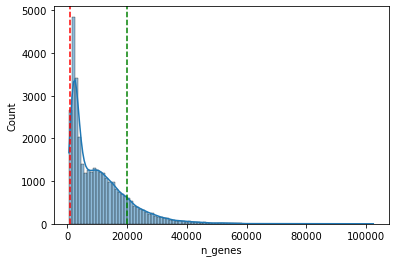

In [24]:
# Histograms of n_genes 
sns.histplot(adata.obs['n_genes'], bins = 100, kde=True)
plt.axvline(1000, linestyle = '--', color = 'red')
plt.axvline(20000, linestyle = '--', color = 'green')

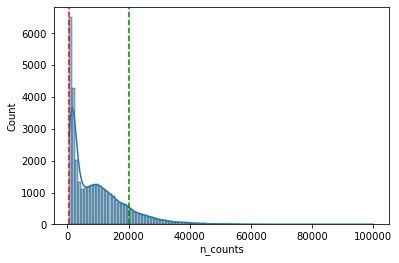

In [25]:
# Histograms of n_counts
sns.histplot(adata.obs['n_counts'], bins = 100, kde=True)
plt.axvline(500, linestyle = '--', color = 'red')
plt.axvline(20000, linestyle = '--', color = 'green')

<AxesSubplot:xlabel='percent_mito', ylabel='Count'>

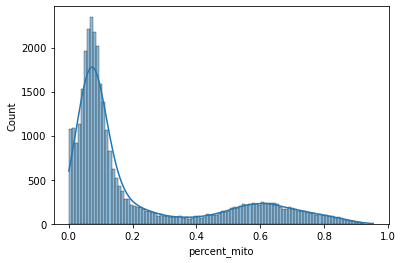

In [26]:
# Histograms of percent_mito
sns.histplot(adata.obs['percent_mito'], bins = 100, kde=True)

In [27]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_cells(adata, min_counts = 500)
#sc.pp.filter_cells(adata, max_genes=10000)
adata = adata[adata.obs['percent_mito'] < 0.2, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


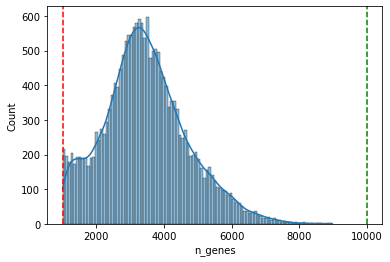

In [28]:
# Histograms of n_genes and percent_mito
sns.histplot(adata.obs['n_genes'], bins = 100, kde=True)
plt.axvline(1000, linestyle = '--', color = 'red')
plt.axvline(10000, linestyle = '--', color = 'green')

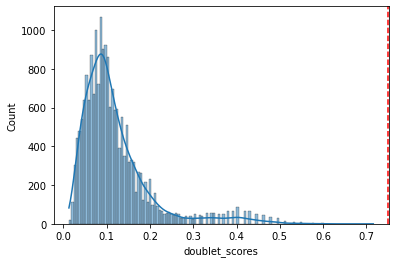

In [29]:
# Histograms of doublet scores
sns.histplot(adata.obs['doublet_scores'], kde=True)
plt.axvline(0.75, linestyle = '--', color = 'red')

In [30]:
sc.external.pp.hashsolo(adata, cell_hashing_columns = sample_htos, number_of_noise_barcodes = len(sample_htos)-2,
                        priors=[0.01, 0.8, 0.19], inplace=True)

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


Trying to set attribute `.obs` of view, copying.


... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'termination' as categorical
... storing 'day' as categorical
... storing 'pcw' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical


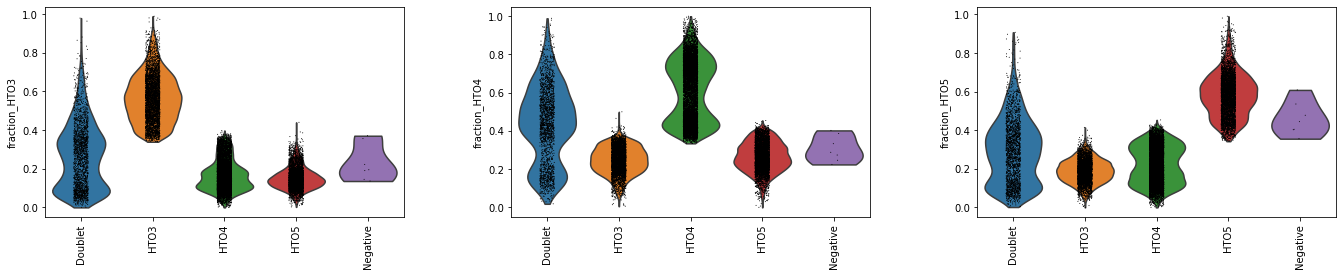

In [31]:
fract_hto = [col for col in adata.obs if col.startswith('fraction_HTO')]
sc.pl.violin(adata, keys=fract_hto, groupby='Classification', rotation=90)

In [32]:
cross = pd.crosstab(adata.obs['Classification'], adata.obs['sample'])
cross

sample,Pla_HDBR12261976_Pla_HDBR12261978,Pla_HDBR12261977_Pla_HDBR12261979
Classification,,
Doublet,835,1186
HTO3,2306,2012
HTO4,3308,5141
HTO5,1820,2992
Negative,3,4


<AxesSubplot:xlabel='Classification'>

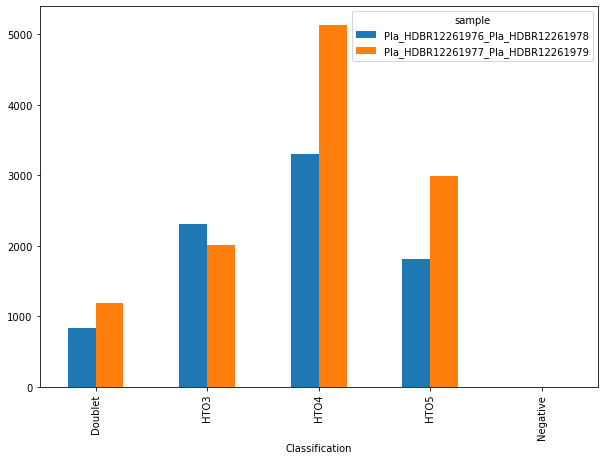

In [33]:
cross.plot(kind='bar', figsize=(10,7), grid=False)

In [34]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

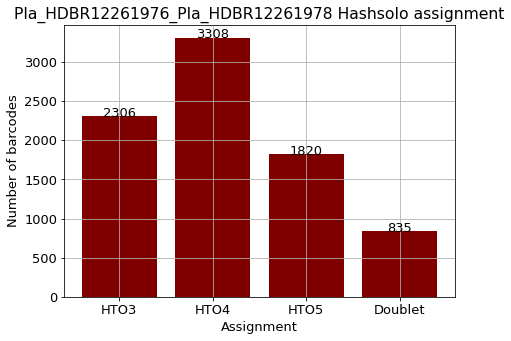

In [35]:
# creating data on which bar chart will be plot
x = ['HTO3', 'HTO4', 'HTO5', 'Doublet']
y=[2306,3308,1820,835]

#y=[1321,2051,1125,341]
#y = [4400, 7822, 2158, 1632]
      
# setting figure size by using figure() function 
plt.figure(figsize = (7,5))
plt.rcParams.update({'font.size': 13})
      
# making the bar chart on the data
plt.bar(x, y, color = 'maroon')
      
# calling the function to add value labels
addlabels(x, y)
      
# giving title to the plot
plt.title("Pla_HDBR12261976_Pla_HDBR12261978 Hashsolo assignment")
      
# giving X and Y labels
plt.xlabel("Assignment")
plt.ylabel("Number of barcodes")
plt.grid()
plt.savefig('Pla_HDBR12261976_Pla_HDBR12261978.pdf')
# visualizing the plot
plt.show()


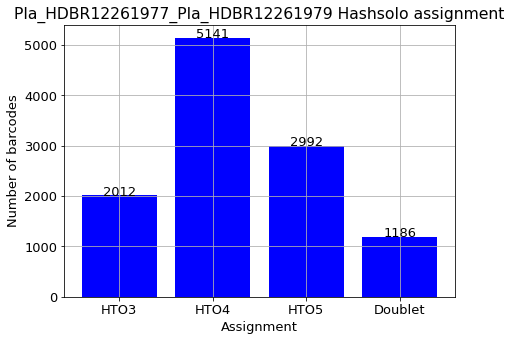

In [36]:
# creating data on which bar chart will be plot
x = ['HTO3', 'HTO4', 'HTO5', 'Doublet']
y=[2012,5141,2992, 1186]
#y=[1417,3820,2049, 542]
#y = [4400, 7822, 2158, 1632]
      
# setting figure size by using figure() function 
plt.figure(figsize = (7,5))
plt.rcParams.update({'font.size': 13})
      
# making the bar chart on the data
plt.bar(x, y, color = 'blue')
      
# calling the function to add value labels
addlabels(x, y)
      
# giving title to the plot
plt.title("Pla_HDBR12261977_Pla_HDBR12261979 Hashsolo assignment")
      
# giving X and Y labels
plt.xlabel("Assignment")
plt.ylabel("Number of barcodes")
plt.grid()
plt.savefig("Pla_HDBR12261977_Pla_HDBR12261979.pdf")
# visualizing the plot
plt.show()


In [37]:
adata.obs['Classification'].value_counts()

HTO4        8449
HTO5        4812
HTO3        4318
Doublet     2021
Negative       7
Name: Classification, dtype: int64

In [39]:
# adding the raw counts
adata.layers['raw_counts']=adata.X

In [40]:
adata.write('rna1_counts_HTO_adata_new.h5ad')